## The warren buffet comparator function

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from scipy import stats
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

# Compare with Buffett function
def compare_with_buffett_fixed(strategy_returns, strategy_name="Our Strategy", initial_capital=100000, 
                         start_date=None, end_date=None, trading_dates=None, position_series=None,
                         asset_data=None):
    # Determine trading dates
    if trading_dates is None:
        if isinstance(strategy_returns, pd.Series) or isinstance(strategy_returns, pd.DataFrame):
            trading_dates = strategy_returns.index
        else:
            if start_date is None or end_date is None:
                raise ValueError("Must provide either trading_dates or start_date and end_date")
            trading_dates = pd.date_range(start=start_date, end=end_date, freq='B')
    
    # Download Buffett data
    try:
        brk_b = yf.download('BRK-B', start=trading_dates[0], end=trading_dates[-1] + pd.DateOffset(days=1))
        brk_b = brk_b.reindex(trading_dates)
        brk_b['log_return'] = np.log(brk_b['Close']).diff().fillna(0)
    except Exception as e:
        print(f"Warning: Error downloading Buffett data: {e}")
        brk_b = pd.DataFrame(index=trading_dates)
        brk_b['Close'] = 100 * (1 + np.random.normal(0.0002, 0.01, size=len(trading_dates))).cumprod()
        brk_b['log_return'] = np.log(brk_b['Close']).diff().fillna(0)
    
    # Initialize results DataFrame
    results = pd.DataFrame(index=trading_dates)
    
    # Process strategy returns or position signals
    if position_series is not None:
        # We have position signals, so need asset price data
        if asset_data is None:
            asset_ticker = position_series.name if hasattr(position_series, 'name') else 'TSLA'
            try:
                asset_data = yf.download(asset_ticker, start=trading_dates[0], end=trading_dates[-1] + pd.DateOffset(days=1))
                asset_data = asset_data.reindex(trading_dates)
            except Exception as e:
                print(f"Warning: Error downloading asset data: {e}")
                asset_data = pd.DataFrame(index=trading_dates)
                asset_data['Close'] = 100 * (1 + np.random.normal(0.0003, 0.02, size=len(trading_dates))).cumprod()
        
        # Ensure asset_data has log_return column
        if 'log_return' not in asset_data.columns:
            asset_data['log_return'] = np.log(asset_data['Close']).diff().fillna(0)
        
        # Calculate strategy returns from positions
        results['position'] = position_series
        results['asset_return'] = asset_data['log_return']
        results['strategy_return'] = results['position'].shift(1) * results['asset_return']
        results['strategy_return'].iloc[0] = 0  # No return on first day
    else:
        # We already have strategy returns
        results['strategy_return'] = strategy_returns
    
    # Calculate cumulative returns and account balances
    results['strategy_cum_return'] = (1 + results['strategy_return']).cumprod() - 1
    results['strategy_balance'] = initial_capital * (1 + results['strategy_cum_return'])
    results['buffett_return'] = brk_b['log_return']
    results['buffett_cum_return'] = (1 + results['buffett_return']).cumprod() - 1
    results['buffett_balance'] = initial_capital * (1 + results['buffett_cum_return'])
    
    # Calculate buy & hold returns for the asset (if we have asset data)
    if 'asset_return' in results.columns:
        results['asset_cum_return'] = (1 + results['asset_return']).cumprod() - 1
        results['asset_balance'] = initial_capital * (1 + results['asset_cum_return'])
    
    # Calculate performance metrics
    days = len(results)
    annualization_factor = 252 / days
    
    # Function to calculate maximum drawdown
    def calculate_max_drawdown(returns):
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.cummax()
        drawdown = (cumulative / running_max) - 1
        return drawdown.min()
    
    # Calculate metrics
    strategy_annual_return = (1 + results['strategy_cum_return'].iloc[-1]) ** annualization_factor - 1
    strategy_sharpe = results['strategy_return'].mean() / results['strategy_return'].std() * np.sqrt(252)
    strategy_max_dd = calculate_max_drawdown(results['strategy_return'])
    strategy_volatility = results['strategy_return'].std() * np.sqrt(252)
    
    buffett_annual_return = (1 + results['buffett_cum_return'].iloc[-1]) ** annualization_factor - 1
    buffett_sharpe = results['buffett_return'].mean() / results['buffett_return'].std() * np.sqrt(252)
    buffett_max_dd = calculate_max_drawdown(results['buffett_return'])
    buffett_volatility = results['buffett_return'].std() * np.sqrt(252)
    
    # Asset metrics (if available)
    if 'asset_return' in results.columns:
        asset_name = asset_ticker if 'asset_ticker' in locals() else 'Asset'
        asset_annual_return = (1 + results['asset_cum_return'].iloc[-1]) ** annualization_factor - 1
        asset_sharpe = results['asset_return'].mean() / results['asset_return'].std() * np.sqrt(252)
        asset_max_dd = calculate_max_drawdown(results['asset_return'])
        asset_volatility = results['asset_return'].std() * np.sqrt(252)
    
    # Create performance summary table
    metrics = ['Total Return', 'Annual Return', 'Sharpe Ratio', 'Maximum Drawdown', 
               'Annual Volatility', 'Final Balance', 'Win Rate']
    
    summary_data = {
        'Metric': metrics,
        f'{strategy_name}': [
            f"{results['strategy_cum_return'].iloc[-1]:.2%}", 
            f"{strategy_annual_return:.2%}", 
            f"{strategy_sharpe:.2f}", 
            f"{strategy_max_dd:.2%}", 
            f"{strategy_volatility:.2%}",
            f"${results['strategy_balance'].iloc[-1]:,.2f}",
            f"{(results['strategy_return'] > 0).mean():.2%}"
        ],
        'Warren Buffett (BRK-B)': [
            f"{results['buffett_cum_return'].iloc[-1]:.2%}", 
            f"{buffett_annual_return:.2%}", 
            f"{buffett_sharpe:.2f}", 
            f"{buffett_max_dd:.2%}", 
            f"{buffett_volatility:.2%}",
            f"${results['buffett_balance'].iloc[-1]:,.2f}",
            f"{(results['buffett_return'] > 0).mean():.2%}"
        ]
    }
    
    if 'asset_return' in results.columns:
        summary_data[f'{asset_name} Buy & Hold'] = [
            f"{results['asset_cum_return'].iloc[-1]:.2%}", 
            f"{asset_annual_return:.2%}", 
            f"{asset_sharpe:.2f}", 
            f"{asset_max_dd:.2%}", 
            f"{asset_volatility:.2%}",
            f"${results['asset_balance'].iloc[-1]:,.2f}",
            f"{(results['asset_return'] > 0).mean():.2%}"
        ]
    
    summary_df = pd.DataFrame(summary_data)
    
    # Display results
    print(f"\n===== {strategy_name} vs. Warren Buffett Performance Summary =====")
    display(HTML(summary_df.to_html(index=False, classes='table table-striped table-hover')))
    
    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(results.index, results['strategy_cum_return'] * 100, label=f'{strategy_name}', linewidth=2)
    plt.plot(results.index, results['buffett_cum_return'] * 100, label='Warren Buffett (BRK-B)', linewidth=2)
    if 'asset_return' in results.columns:
        plt.plot(results.index, results['asset_cum_return'] * 100, label=f'{asset_name} Buy & Hold', linewidth=2)
    plt.title('Cumulative Return Comparison (%)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return (%)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return {'results': results, 'summary': summary_df}

## PREPROCESSING AND CUSTOM POSITIONING

In [2]:
# Data leakage removal function
def enhanced_remove_data_leakage(df, verbose=True):
    """Enhanced function to remove more subtle data leakage sources"""
    
    # Define patterns for features that likely cause data leakage
    leakage_patterns = [
        # Market indicators and external data
        'VIXCLS', 'SP500', 'ADS_Index', 'DCOILWTICO', 'DCOILBRENTEU',
        '_Tech_Giants', '_Traditional_Auto', '_ETFs',
        'Return_1D', 'Return_5D', 'Return_1M',
        'T10YIE', 'T5YIE', 'DGS10', 'T10Y3M', 'BAMLH0A0HYM2', 'AMERIBOR',
        
        # Technical indicators using today's data
        'close_open_ratio', 'high_low_ratio', 'rsi', 'macd', 'bb_', 'atr', 'adx', 'cci',
        'sma_', 'trend_strength', 'momentum_', 'percentile'
    ]
    
    # Safe features to keep
    safe_features = ['open', 'high', 'low', 'close', 'volume', 'log_return']
    
    # Collect columns to drop
    cols_to_drop = []
    for pattern in leakage_patterns:
        matching_cols = [col for col in df.columns if pattern in col]
        cols_to_drop.extend(matching_cols)
    
    # Remove duplicates
    cols_to_drop = list(set(cols_to_drop))
    
    # Keep safe features
    for safe_feature in safe_features:
        if safe_feature in cols_to_drop and safe_feature in df.columns:
            cols_to_drop.remove(safe_feature)
    
    # Create clean dataframe
    clean_df = df.drop(columns=cols_to_drop, errors='ignore')
    
    # Add properly lagged features
    if 'close' in clean_df.columns:
        # Create log_return if it doesn't exist
        if 'log_return' not in clean_df.columns:
            clean_df['log_return'] = np.log(clean_df['close']).diff()
            
        # Lagged price features
        for lag in [1, 2, 3, 5, 10, 20]:
            clean_df[f'close_lag_{lag}'] = clean_df['close'].shift(lag)
            clean_df[f'price_change_{lag}d'] = clean_df['close'].pct_change(lag).shift(1)
            if 'volume' in clean_df.columns:
                clean_df[f'volume_lag_{lag}'] = clean_df['volume'].shift(lag)
        
        # Lagged return features
        clean_df['return_lag_1'] = clean_df['close'].pct_change(1).shift(1)
        clean_df['return_lag_5'] = clean_df['close'].pct_change(5).shift(1)
        clean_df['return_lag_10'] = clean_df['close'].pct_change(10).shift(1)
        
        # Lagged volatility
        returns = clean_df['close'].pct_change().shift(1)
        for window in [5, 10, 20]:
            clean_df[f'volatility_{window}d_lag'] = returns.rolling(window).std().shift(1)
    
    if verbose:
        print(f"Removed {len(cols_to_drop)} potentially leaking features")
        print(f"Remaining features: {len(clean_df.columns)}")
    
    return clean_df

# Position sizing function
def apply_stop_loss(positions, prices, initial_stop_pct=0.15, trailing_stop_pct=0.10):
    adjusted_positions = positions.copy()
    in_position = False
    entry_price = 0
    stop_price = 0
    position_type = 0  # 0=none, 1=long, -1=short
    
    for i in range(1, len(adjusted_positions)):
        curr_price = prices.iloc[i]
        prev_price = prices.iloc[i-1]
        
        # If we're not in a position and getting a new signal
        if not in_position and adjusted_positions.iloc[i] != 0:
            in_position = True
            entry_price = curr_price
            position_type = 1 if adjusted_positions.iloc[i] > 0 else -1
            
            # Set initial stop loss
            if position_type == 1:  # Long position
                stop_price = entry_price * (1 - initial_stop_pct)
            else:  # Short position
                stop_price = entry_price * (1 + initial_stop_pct)
        
        # If we're in a position
        elif in_position:
            # Check if stop loss was hit
            if (position_type == 1 and curr_price < stop_price) or \
               (position_type == -1 and curr_price > stop_price):
                # Stop loss hit - exit position
                adjusted_positions.iloc[i] = 0
                in_position = False
                position_type = 0
            
            # Update trailing stop if price moved favorably
            elif position_type == 1 and curr_price > prev_price:  # Long position
                new_stop = curr_price * (1 - trailing_stop_pct)
                if new_stop > stop_price:
                    stop_price = new_stop
            
            elif position_type == -1 and curr_price < prev_price:  # Short position
                new_stop = curr_price * (1 + trailing_stop_pct)
                if new_stop < stop_price or stop_price == 0:
                    stop_price = new_stop
            
            # Check if position direction changed in signal
            if (position_type == 1 and adjusted_positions.iloc[i] < 0) or \
               (position_type == -1 and adjusted_positions.iloc[i] > 0):
                # Exit old position and enter new one
                in_position = True
                entry_price = curr_price
                position_type = 1 if adjusted_positions.iloc[i] > 0 else -1
                
                # Reset stop loss for new position
                if position_type == 1:  # Long position
                    stop_price = entry_price * (1 - initial_stop_pct)
                else:  # Short position
                    stop_price = entry_price * (1 + initial_stop_pct)
            
            # If signal goes to zero, exit position
            elif adjusted_positions.iloc[i] == 0:
                in_position = False
                position_type = 0
    
    return adjusted_positions

def custom_position_sizing(df, predictions, model, X_pca, max_risk_per_trade=0.03):
    # Create position DataFrame
    positions_df = pd.DataFrame(index=predictions.index)
    positions_df['prediction'] = predictions
    
    # Calculate standard error for each prediction
    X_with_const = sm.add_constant(X_pca.loc[predictions.index])
    prediction_stats = model.get_prediction(X_with_const)
    positions_df['prediction_std'] = prediction_stats.summary_frame()['mean_se']
    
    # Calculate t-statistic for confidence
    positions_df['t_stat'] = positions_df['prediction'] / positions_df['prediction_std']
    
    # Get market volatility (check if column exists)
    if 'volatility_20d_lag' in df.columns:
        positions_df['volatility'] = df.loc[predictions.index, 'volatility_20d_lag']
    else:
        positions_df['volatility'] = 0.02  # Default value
    
    # Position size calculation
    positions_df['raw_position'] = np.sign(positions_df['prediction']) * np.minimum(
        np.abs(positions_df['prediction'] * 40), 1.0
    )
    
    # Adjust for confidence
    confidence_factor = np.minimum(np.abs(positions_df['t_stat']) / 1.5, 1.0)
    positions_df['raw_position'] = positions_df['raw_position'] * confidence_factor
    
    # Adjust for volatility (reduce position in high volatility)
    vol_factor = 1.0 - np.minimum(positions_df['volatility'] * 5, 0.3)
    positions_df['raw_position'] = positions_df['raw_position'] * vol_factor
    
    # Apply stop loss logic
    if 'close' in df.columns:
        positions_df['position'] = apply_stop_loss(
            positions_df['raw_position'],
            df.loc[predictions.index, 'close'],
            initial_stop_pct=0.30,
            trailing_stop_pct=0.10
        )
    else:
        positions_df['position'] = positions_df['raw_position']
    
    # Risk management
    positions_df['risk_factor'] = 0.02  # Default risk factor
    
    # Calculate risk-adjusted position size
    positions_df['risk_adjusted_size'] = max_risk_per_trade / positions_df['risk_factor']
    
    # Final position size
    positions_df['final_position'] = np.sign(positions_df['position']) * np.minimum(
        abs(positions_df['position']),
        positions_df['risk_adjusted_size']
    )
    
    # Apply trend factors if available
    if 'price_change_20d' in df.columns and 'price_change_50d' in df.columns:
        positions_df['market_trend'] = np.sign(
            df.loc[predictions.index, 'price_change_20d'] - df.loc[predictions.index, 'price_change_50d']
        )
        positions_df['momentum'] = df.loc[predictions.index, 'price_change_20d']
        
        # Apply more leverage when trend and prediction align
        leverage_factor = np.where(
            (positions_df['market_trend'] * np.sign(positions_df['final_position']) > 0) & 
            (np.abs(positions_df['momentum']) > 0.02),
            1.5, 1.0
        )
        
        positions_df['final_position'] = positions_df['final_position'] * leverage_factor
        
    positions_df['final_position'] = np.clip(positions_df['final_position'], -1.0, 1.0)
    
    return positions_df

## PCA FOR FEATURE EXTRACTION, OLS FOR REGRESSION, FORWARD WALK FOR VALIDATION

Applying enhanced data leakage removal...
Removed 15 potentially leaking features
Remaining features: 63

Running leak-free PCA model with proper validation...

Leak-Free PCA Model Implementation
--------------------------------------------------
Training: 2020-02-11 00:00:00 to 2021-02-23 00:00:00
Testing:  2021-02-24 00:00:00 to 2021-05-26 00:00:00
Training RMSE: nan
Training R²: nan
Test RMSE: nan
Test R²: 1.0000
Window Return: 0.00%, Train R: nan
--------------------------------------------------
Training: 2020-05-14 00:00:00 to 2021-05-26 00:00:00
Testing:  2021-05-27 00:00:00 to 2021-08-25 00:00:00
Training RMSE: 0.044157
Training R²: 0.0298
Test RMSE: 0.021952
Test R²: -0.0058
Window Return: -0.05%, Train R: 0.1725
--------------------------------------------------
Training: 2020-08-13 00:00:00 to 2021-08-25 00:00:00
Testing:  2021-08-26 00:00:00 to 2021-11-30 00:00:00
Training RMSE: 0.040395
Training R²: 0.0159
Test RMSE: 0.030900
Test R²: 0.0339
Window Return: 11.62%, Train R:

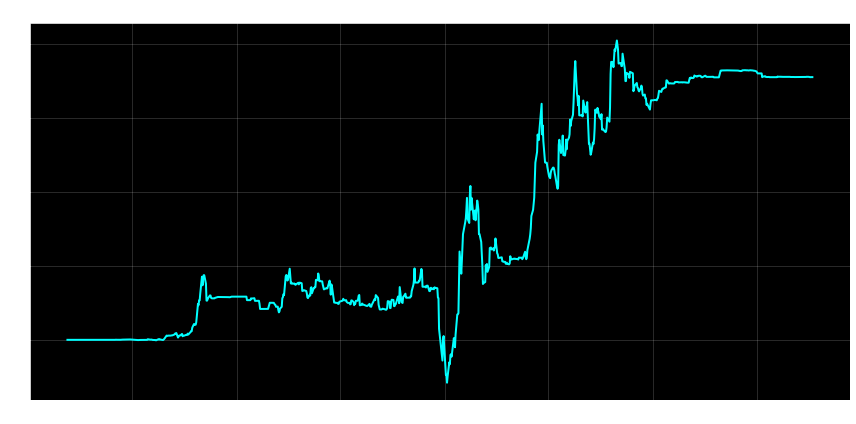

[*********************100%***********************]  1 of 1 completed


===== Forward-Walk PCA Strategy vs. Warren Buffett Performance Summary =====


Metric,Forward-Walk PCA Strategy,Warren Buffett (BRK-B),Asset Buy & Hold
Total Return,66.24%,63.22%,-24.67%
Annual Return,17.15%,16.49%,-8.45%
Sharpe Ratio,0.83,0.94,0.14
Maximum Drawdown,-27.70%,-27.68%,-76.46%
Annual Volatility,22.03%,17.85%,58.27%
Final Balance,"$166,235.97","$163,220.84","$75,327.25"
Win Rate,50.43%,53.28%,52.90%


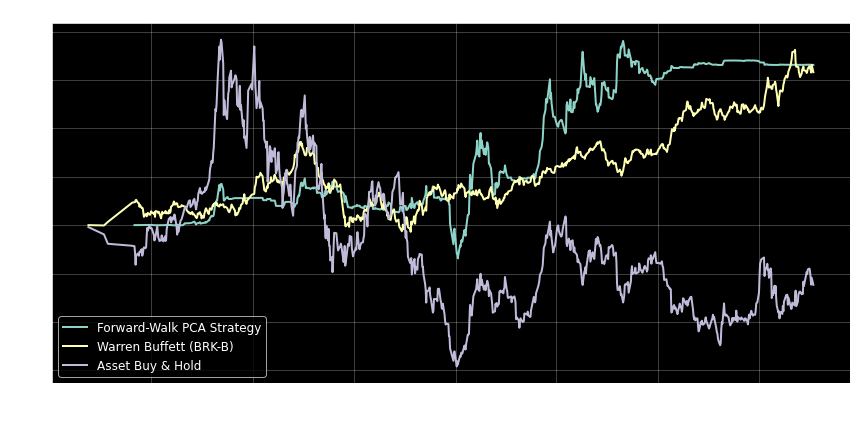

In [4]:
# Core PCA model function
def create_leak_free_pca_model(df, train_window=252, test_window=63):
    print("\nLeak-Free PCA Model Implementation")
    print("-" * 50)
    
    # Prepare features and target - make sure log_return exists
    if 'log_return' not in df.columns and 'close' in df.columns:
        df['log_return'] = np.log(df['close']).diff()
    
    # Prepare features and target
    y = df['log_return'].copy()
    features = df.drop(['open', 'high', 'low', 'close', 'volume', 'log_return'], axis=1, errors='ignore')
    
    # Standard data cleaning
    features = features.replace([np.inf, -np.inf], np.nan)
    features = features.fillna(method='ffill').fillna(method='bfill')
    
    # Ensure data alignment
    common_idx = y.index.intersection(features.index)
    y = y.loc[common_idx]
    features = features.loc[common_idx]
    df_clean = df.loc[common_idx]
    
    # Initialize storage for results
    all_oos_positions = []
    all_oos_returns = []
    
    # Forward walking window
    start_idx = train_window
    while start_idx + test_window <= len(y):
        # Define window indices
        train_end = start_idx
        train_start = train_end - train_window
        test_end = min(train_end + test_window, len(y))
        
        # Extract window data
        X_train = features.iloc[train_start:train_end]
        y_train = y.iloc[train_start:train_end]
        X_test = features.iloc[train_end:test_end]
        y_test = y.iloc[train_end:test_end]
        
        # Record window dates
        window_start = y.index[train_end]
        window_end = y.index[test_end-1] if test_end < len(y) else y.index[-1]
        print(f"Training: {y.index[train_start]} to {y.index[train_end-1]}")
        print(f"Testing:  {window_start} to {window_end}")
        
        # Scale data
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # PCA transformation
        pca = PCA(n_components=0.8)
        train_pca = pca.fit_transform(X_train_scaled)
        test_pca = pca.transform(X_test_scaled)
        
        # Create PCA DataFrames
        pca_cols = [f'PC{i+1}' for i in range(train_pca.shape[1])]
        X_train_pca = pd.DataFrame(train_pca, columns=pca_cols, index=X_train.index)
        X_test_pca = pd.DataFrame(test_pca, columns=pca_cols[:test_pca.shape[1]], index=X_test.index)
        
        # Add non-linear transformations
        n_components = min(10, X_train_pca.shape[1])
        for i in range(n_components):
            if i < len(pca_cols) and f'PC{i+1}' in X_test_pca.columns:
                if i < 5:  # Cubic terms for top 5 components
                    X_train_pca[f'PC{i+1}_cubic'] = X_train_pca[f'PC{i+1}'] ** 3
                    X_test_pca[f'PC{i+1}_cubic'] = X_test_pca[f'PC{i+1}'] ** 3
                
                X_train_pca[f'PC{i+1}_squared'] = X_train_pca[f'PC{i+1}'] ** 2
                X_test_pca[f'PC{i+1}_squared'] = X_test_pca[f'PC{i+1}'] ** 2
        
        # Add interaction terms
        for i in range(min(5, n_components)):
            for j in range(i+1, min(5, n_components)):
                if f'PC{i+1}' in X_test_pca.columns and f'PC{j+1}' in X_test_pca.columns:
                    X_train_pca[f'PC{i+1}_PC{j+1}'] = X_train_pca[f'PC{i+1}'] * X_train_pca[f'PC{j+1}']
                    X_test_pca[f'PC{i+1}_PC{j+1}'] = X_test_pca[f'PC{i+1}'] * X_test_pca[f'PC{j+1}']
        
        # Train model
        X_train_const = sm.add_constant(X_train_pca)
        model = sm.OLS(y_train, X_train_const).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
        
        # Evaluate in-sample performance
        train_pred = model.predict(X_train_const)
        train_corr = np.corrcoef(y_train, train_pred)[0, 1]
        
        # Make predictions on test set
        missing_cols = set(X_train_pca.columns) - set(X_test_pca.columns)
        for col in missing_cols:
            X_test_pca[col] = 0
            
        X_test_pca = X_test_pca[X_train_pca.columns]  # Ensure same column order
        X_test_const = sm.add_constant(X_test_pca)
        test_pred = model.predict(X_test_const)
        
        # Calculate RMSE and R² for training set
        train_rmse = np.sqrt(np.mean((y_train - train_pred) ** 2))
        train_r2 = model.rsquared

        # Calculate RMSE and R² for test set
        test_rmse = np.sqrt(np.mean((y_test - test_pred) ** 2))
        test_r2 = 1 - (np.sum((y_test - test_pred) ** 2) / np.sum((y_test - y_test.mean()) ** 2))

        # Print metrics for this window
        print(f"Training RMSE: {train_rmse:.6f}")
        print(f"Training R²: {train_r2:.4f}")
        print(f"Test RMSE: {test_rmse:.6f}")
        print(f"Test R²: {test_r2:.4f}")
        
        # Calculate positions
        df_test_window = df_clean.loc[y_test.index]
        positions_df = custom_position_sizing(df_test_window, test_pred, model, X_test_pca)
        
        # Calculate returns
        window_returns = positions_df['final_position'].shift(1) * y_test
        window_returns = window_returns.dropna()
        
        # Store results
        all_oos_returns.append(window_returns)
        all_oos_positions.append(positions_df['final_position'])
        
        # Print window metrics
        window_cum_return = (1 + window_returns.fillna(0)).cumprod().iloc[-1] - 1
        print(f"Window Return: {window_cum_return:.2%}, Train R: {train_corr:.4f}")
        print("-" * 50)
        
        # Move forward
        start_idx = test_end
    
    # Combine all out-of-sample results
    combined_returns = pd.concat(all_oos_returns)
    combined_positions = pd.concat(all_oos_positions)
    
    # Calculate overall performance
    cum_returns = (1 + combined_returns.fillna(0)).cumprod()
    oos_return = cum_returns.iloc[-1] - 1
    oos_annual_return = (1 + oos_return) ** (252/len(combined_returns)) - 1
    oos_volatility = combined_returns.std() * np.sqrt(252)
    oos_sharpe = oos_annual_return / oos_volatility if oos_volatility > 0 else 0
    
    # Calculate drawdown
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns / rolling_max) - 1
    max_drawdown = drawdown.min()
    
    # Print overall results
    print("\nLeak-Free Model Test Results:")
    print(f"Total Return: {oos_return:.2%}")
    print(f"Annualized Return: {oos_annual_return:.2%}")
    print(f"Sharpe Ratio: {oos_sharpe:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    print(f"Win Rate: {(combined_returns > 0).mean():.2%}")
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(cum_returns, color='cyan', linewidth=2)
    plt.title('Leak-Free PCA Model: Cumulative Returns', fontsize=14)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()
    
    return combined_returns, combined_positions

# Main execution
# Load data
df = pd.read_csv('INFO6105_Final_TSLA_FeatureMart (1).xls')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Clean data
print("Applying enhanced data leakage removal...")
df_clean = enhanced_remove_data_leakage(df, verbose=True)

# Run PCA model
print("\nRunning leak-free PCA model with proper validation...")
leak_free_returns, leak_free_positions = create_leak_free_pca_model(df_clean, train_window=252, test_window=63)

# Prepare asset data for comparison
asset_data = df.copy()
if 'log_return' not in asset_data.columns:
    asset_data['log_return'] = np.log(asset_data['close']).diff()

# Compare with Warren Buffett
compare_with_buffett_fixed(
    strategy_returns=leak_free_returns,
    strategy_name="Forward-Walk PCA Strategy",
    initial_capital=100000,
    position_series=leak_free_positions,
    asset_data=asset_data
);